<a href="https://colab.research.google.com/github/anushree415/Deep-learning-Assignment/blob/main/CNN_FLOWERS_TRANSFER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Anushree.D
Transfer Learning on TensorFlow Flowers

In [11]:

import os, nbformat, json
from google.colab import files
from pathlib import Path

def list_content():
    print("Current working dir:", os.getcwd())
    print("\nFiles in /content:")
    !ls -la /content

def find_ipynb():
    ipynbs = [p for p in os.listdir('/content') if p.lower().endswith('.ipynb')]
    return ipynbs

def clean_notebook(in_path, out_path):
    nb = nbformat.read(in_path, as_version=nbformat.NO_CONVERT)
    changed = False

    # top-level fix: if widgets exists and no state, add empty state
    widgets_meta = nb.get('metadata', {}).get('widgets')
    if isinstance(widgets_meta, dict) and 'state' not in widgets_meta:
        nb['metadata']['widgets']['state'] = {}
        changed = True

    # remove or fix widgets in cells
    for cell in nb.get('cells', []):
        meta = cell.get('metadata', {})
        if 'widgets' in meta:
            w = meta['widgets']
            # if widgets is a dict but missing state, add it
            if isinstance(w, dict) and 'state' not in w:
                meta['widgets']['state'] = {}
                changed = True
            # if widgets is not useful, remove it entirely (safe)
            # NOTE: removing ensures GitHub preview works
            try:
                meta.pop('widgets', None)
                changed = True
            except Exception:
                pass

    nbformat.write(nb, out_path)
    return changed

# Step 1: show files
list_content()

# Step 2: find ipynb files
ipynb_files = find_ipynb()
if not ipynb_files:
    print("\nNo .ipynb files found in /content. Please upload your .ipynb now.")
    uploaded = files.upload()
    if uploaded:
        print("Uploaded:", list(uploaded.keys()))
        ipynb_files = find_ipynb()

if not ipynb_files:
    raise FileNotFoundError("No .ipynb file found. Upload the notebook (File -> Upload in left Files pane or use files.upload()).")

# If multiple, ask user to choose by index
if len(ipynb_files) > 1:
    print("\nMultiple notebooks found:")
    for i, name in enumerate(ipynb_files):
        print(f"[{i}] {name}")
    sel = input("\nEnter the index number of the notebook you want to clean (e.g. 0): ").strip()
    try:
        idx = int(sel)
        in_name = ipynb_files[idx]
    except Exception:
        print("Invalid selection, choosing first notebook.")
        in_name = ipynb_files[0]
else:
    in_name = ipynb_files[0]

in_path = os.path.join('/content', in_name)
out_name = in_name.replace('.ipynb', '') + '_clean.ipynb'
out_path = os.path.join('/content', out_name)

print(f"\nCleaning notebook:\n  Input:  {in_path}\n  Output: {out_path}")

# sanity check existence
if not os.path.exists(in_path):
    raise FileNotFoundError(f"Expected notebook not found: {in_path}")

changed = clean_notebook(in_path, out_path)
print("Cleaning done. Any metadata.widgets removed/adjusted?:", changed)
print("Output file size (bytes):", os.path.getsize(out_path))

# Try to download the cleaned file to your machine
try:
    files.download(out_path)
except Exception as e:
    print("files.download failed (browser may block). You can still find the cleaned file at:", out_path)

# Also try to copy to Drive for convenience (if you want). Ask user.
if input("\nMount Google Drive and save a copy there? (y/N): ").strip().lower() == 'y':
    from google.colab import drive
    drive.mount('/content/drive')
    dst = '/content/drive/MyDrive/' + out_name
    import shutil
    shutil.copy(out_path, dst)
    print("Copied cleaned notebook to Drive:", dst)

print("\nNow upload the cleaned notebook (_clean.ipynb) to GitHub (repo -> Add file -> Upload files) or use File -> Save a copy in GitHub from Colab.")


Current working dir: /content

Files in /content:
total 32
drwxr-xr-x 1 root root 4096 Nov 15 04:31  .
drwxr-xr-x 1 root root 4096 Nov 15 04:02  ..
-rw-r--r-- 1 root root 3707 Nov 15 04:31 'CNN_FLOWERS_TRANSFER_clean_minimal (1).ipynb'
-rw-r--r-- 1 root root 3707 Nov 15 04:07  CNN_FLOWERS_TRANSFER_clean_minimal.ipynb
drwxr-xr-x 4 root root 4096 Nov 12 14:30  .config
drwxr-xr-x 2 root root 4096 Nov 15 04:26  models
drwxr-xr-x 2 root root 4096 Nov 15 04:26  results
drwxr-xr-x 1 root root 4096 Nov 12 14:30  sample_data

Multiple notebooks found:
[0] CNN_FLOWERS_TRANSFER_clean_minimal (1).ipynb
[1] CNN_FLOWERS_TRANSFER_clean_minimal.ipynb

Enter the index number of the notebook you want to clean (e.g. 0): 0

Cleaning notebook:
  Input:  /content/CNN_FLOWERS_TRANSFER_clean_minimal (1).ipynb
  Output: /content/CNN_FLOWERS_TRANSFER_clean_minimal (1)_clean.ipynb
Cleaning done. Any metadata.widgets removed/adjusted?: False
Output file size (bytes): 3707


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

KeyboardInterrupt: Interrupted by user

In [12]:
!ls -lh /content


total 24K
-rw-r--r-- 1 root root 3.7K Nov 15 04:39 'CNN_FLOWERS_TRANSFER_clean_minimal (1)_clean.ipynb'
-rw-r--r-- 1 root root 3.7K Nov 15 04:31 'CNN_FLOWERS_TRANSFER_clean_minimal (1).ipynb'
-rw-r--r-- 1 root root 3.7K Nov 15 04:07  CNN_FLOWERS_TRANSFER_clean_minimal.ipynb
drwxr-xr-x 2 root root 4.0K Nov 15 04:26  models
drwxr-xr-x 2 root root 4.0K Nov 15 04:26  results
drwxr-xr-x 1 root root 4.0K Nov 12 14:30  sample_data


In [10]:
# ---- run this once at top of the notebook ----
import nbformat, os
from google.colab import files

in_name = "CNN_FLOWERS_TRANSFER.ipynb"   # <<< change to exact filename shown in Files pane
out_name = in_name  # overwrite the same filename on disk (or change to different name if you want a backup)

# sanity check
if not os.path.exists(in_name):
    raise FileNotFoundError(f"Notebook file not found in Colab workspace: {in_name}\nCheck exact filename in the left Files pane or upload the .ipynb first.")

# load without converting to avoid version changes
nb = nbformat.read(in_name, as_version=nbformat.NO_CONVERT)

# remove top-level widgets metadata if present
if 'widgets' in nb.get('metadata', {}):
    nb['metadata'].pop('widgets', None)

# remove widgets metadata from each cell
for cell in nb.get('cells', []):
    if 'widgets' in cell.get('metadata', {}):
        cell['metadata'].pop('widgets', None)

# write back (overwrite)
nbformat.write(nb, out_name)
print("Cleaned notebook saved as:", out_name, " (size:", os.path.getsize(out_name), "bytes)")

# optional: download cleaned copy to your computer
try:
    files.download(out_name)
except Exception as e:
    print("files.download failed (browser might block). Cleaned file is still saved in Colab's /content.")


FileNotFoundError: Notebook file not found in Colab workspace: CNN_FLOWERS_TRANSFER.ipynb
Check exact filename in the left Files pane or upload the .ipynb first.

In [1]:
import os
import random
import numpy as np
import tensorflow as tf

SEED = 42
np.random.seed(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)

from tensorflow.keras import layers, models, callbacks
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

os.makedirs('results', exist_ok=True)
os.makedirs('models', exist_ok=True)

print("TensorFlow version:", tf.__version__)


TensorFlow version: 2.19.0


In [2]:
# load dataset (safe, with retries)
try:
    dataset, info = tfds.load('tf_flowers', with_info=True, as_supervised=True)
except Exception as e:
    print("tfds load error:", e)
    raise

print(info)


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/tf_flowers/incomplete.HBRPOI_3.0.1/tf_flowers-train.tfrecord*...:   0%|   …

Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.
tfds.core.DatasetInfo(
    name='tf_flowers',
    full_name='tf_flowers/3.0.1',
    description="""
    A large set of images of flowers
    """,
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    data_dir='/root/tensorflow_datasets/tf_flowers/3.0.1',
    file_format=tfrecord,
    download_size=218.21 MiB,
    dataset_size=221.83 MiB,
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=5),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    nondeterministic_order=False,
    splits={
        'train': <SplitInfo num_examples=3670, num_shards=2>,
    },
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.ten

In [3]:
AUTOTUNE = tf.data.AUTOTUNE
IMG_SIZE = 224
BATCH_SIZE = 32

def format_image(image, label):
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    image = image / 255.0
    return image, label

ds = dataset['train'].map(format_image, num_parallel_calls=AUTOTUNE)
ds = ds.shuffle(1024, seed=SEED)

num_examples = info.splits['train'].num_examples
val_size = int(0.1 * num_examples)

train_ds = ds.skip(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
val_ds   = ds.take(val_size).batch(BATCH_SIZE).prefetch(AUTOTUNE)
num_classes = info.features['label'].num_classes

print("Num classes:", num_classes, "Total examples:", num_examples, "Val size:", val_size)


Num classes: 5 Total examples: 3670 Val size: 367


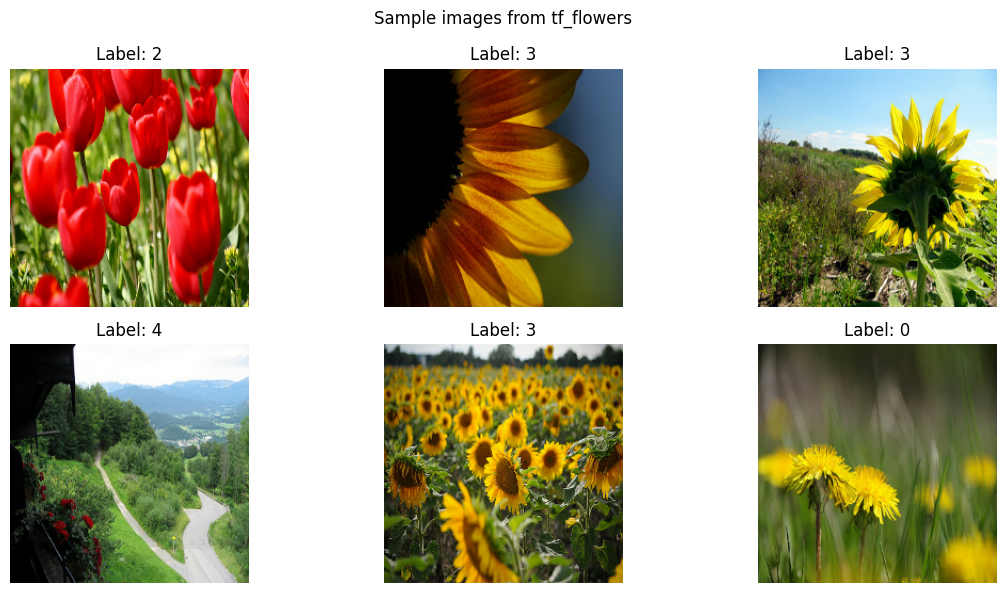

In [4]:
# show 6 samples from train dataset for quick visual check
import itertools
plt.figure(figsize=(12,6))
sample_iter = iter(dataset['train'].map(lambda x,y: (tf.image.resize(x, (IMG_SIZE,IMG_SIZE))/255.0, y)))
for i in range(6):
    img, lbl = next(sample_iter)
    ax = plt.subplot(2,3,i+1)
    plt.imshow(img.numpy())
    plt.title(f"Label: {int(lbl)}")
    plt.axis('off')
plt.suptitle("Sample images from tf_flowers")
plt.tight_layout()
plt.show()


In [5]:
base_model = tf.keras.applications.EfficientNetB0(include_top=False,
                                                  input_shape=(IMG_SIZE,IMG_SIZE,3),
                                                  weights='imagenet')
base_model.trainable = False

inputs = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3))
x = base_model(inputs, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │         6,405 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,055,976 (15.47 MB)

 Trainable params: 6,405 (25.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [6]:
checkpoint_cb = callbacks.ModelCheckpoint('models/flowers_best_head.h5', save_best_only=True, monitor='val_accuracy')
earlystop_cb = callbacks.EarlyStopping(monitor='val_accuracy', patience=4, restore_best_weights=True)

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=6,
                    callbacks=[checkpoint_cb, earlystop_cb])


Epoch 1/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step - accuracy: 0.2287 - loss: 1.6159

104/104 ━━━━━━━━━━━━━━━━━━━━ 70s 386ms/step - accuracy: 0.2287 - loss: 1.6159 - val_accuracy: 0.2507 - val_loss: 1.6058
Epoch 2/6
102/104 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2271 - loss: 1.6236

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 53ms/step - accuracy: 0.2269 - loss: 1.6236 - val_accuracy: 0.2807 - val_loss: 1.5799
Epoch 3/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 48ms/step - accuracy: 0.2412 - loss: 1.6110 - val_accuracy: 0.2534 - val_loss: 1.5934
Epoch 4/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.2606 - loss: 1.6146 - val_accuracy: 0.2452 - val_loss: 1.6114
Epoch 5/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 47ms/step - accuracy: 0.2299 - loss: 1.6221 - val_accuracy: 0.2480 - val_loss: 1.6055
Epoch 6/6
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.2336 - loss: 1.6165

104/104 ━━━━━━━━━━━━━━━━━━━━ 6s 54ms/step - accuracy: 0.2334 - loss: 1.6166 - val_accuracy: 0.3052 - val_loss: 1.5912


In [7]:
# fine-tuning: unfreeze top layers of base model
base_model.trainable = True
fine_tune_at = 100
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5),
              loss='sparse_categorical_crossentropy', metrics=['accuracy'])

checkpoint_cb2 = callbacks.ModelCheckpoint('models/flowers_best_finetune.h5', save_best_only=True, monitor='val_accuracy')
history_fine = model.fit(train_ds,
                         validation_data=val_ds,
                         epochs=6,
                         callbacks=[checkpoint_cb2, earlystop_cb])


Epoch 1/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 0s 320ms/step - accuracy: 0.2572 - loss: 1.6197

104/104 ━━━━━━━━━━━━━━━━━━━━ 99s 440ms/step - accuracy: 0.2575 - loss: 1.6194 - val_accuracy: 0.2616 - val_loss: 1.6060
Epoch 2/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 85ms/step - accuracy: 0.3263 - loss: 1.5227 - val_accuracy: 0.1989 - val_loss: 1.6137
Epoch 3/6
104/104 ━━━━━━━━━━━━━━━━━━━━ 9s 85ms/step - accuracy: 0.3836 - loss: 1.4607 - val_accuracy: 0.1526 - val_loss: 1.6277
Epoch 4/6
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.3997 - loss: 1.4282

104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 89ms/step - accuracy: 0.3999 - loss: 1.4279 - val_accuracy: 0.3978 - val_loss: 1.4692
Epoch 5/6
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4352 - loss: 1.3753

104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 93ms/step - accuracy: 0.4353 - loss: 1.3750 - val_accuracy: 0.4550 - val_loss: 1.3640
Epoch 6/6
103/104 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - accuracy: 0.4645 - loss: 1.3291

104/104 ━━━━━━━━━━━━━━━━━━━━ 10s 94ms/step - accuracy: 0.4644 - loss: 1.3291 - val_accuracy: 0.5177 - val_loss: 1.2463


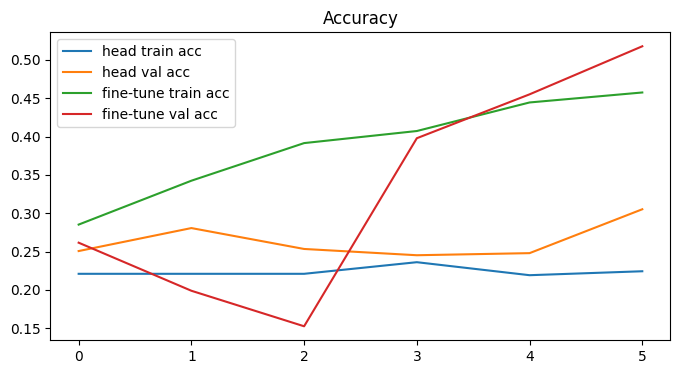

In [8]:
model.save('models/flowers_efficientnetb0.h5')

def plot_hist(h1, h2=None):
    plt.figure(figsize=(8,4))
    if h1:
        plt.plot(h1.history.get('accuracy', []), label='head train acc')
        plt.plot(h1.history.get('val_accuracy', []), label='head val acc')
    if h2:
        plt.plot(h2.history.get('accuracy', []), label='fine-tune train acc')
        plt.plot(h2.history.get('val_accuracy', []), label='fine-tune val acc')
    plt.legend()
    plt.title('Accuracy')
    plt.savefig('results/flowers_transfer_accuracy.png')
    plt.show()

plot_hist(history, globals().get('history_fine') or globals().get('history_fine'))


In [9]:
# load best model and run on one batch
from tensorflow.keras.models import load_model
best_path = 'models/flowers_best_finetune.h5' if os.path.exists('models/flowers_best_finetune.h5') else 'models/flowers_best_head.h5'
m = load_model(best_path)
for images, labels in val_ds.take(1):
    preds = m.predict(images)
    pred_labels = np.argmax(preds, axis=1)
    print("True labels:", labels.numpy()[:8])
    print("Pred labels:", pred_labels[:8])
    break


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
True labels: [3 3 3 1 3 0 3 2]
Pred labels: [2 2 2 2 2 2 2 2]
